In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model


from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

## Creating Training Data

In [21]:
from keras.models import load_model
ANNmodel = load_model('./Models')

ANNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                39768     
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 40393 (157.79 KB)
Trainable params: 40393 (157.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
data = pd.read_csv('final_cleaned.csv')
data.head()

,bathrooms,bedrooms,price,square_feet,time,state_AK,state_AL,state_AR,state_AZ,state_CA,...,Gym,TV,Hot Tub,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf
0,1.0,0.0,790,0.000000,2019-12-26 11:23:35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,425,0.000125,2019-12-22 12:17:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,1390,0.000150,2019-12-26 11:23:30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,925,0.000376,2019-12-18 11:15:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,880,0.000602,2019-12-26 11:23:21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X = data.drop(['price', 'time'], axis=1)
fairness_data = data.copy()
fairness_data['predicted_price'] = ANNmodel.predict(X)
fairness_data.head()

313/313 [==============================] - 1s 2ms/step


,bathrooms,bedrooms,price,square_feet,time,state_AK,state_AL,state_AR,state_AZ,state_CA,...,TV,Hot Tub,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf,predicted_price
0,1.0,0.0,790,0.000000,2019-12-26 11:23:35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1767.783081
1,1.0,1.0,425,0.000125,2019-12-22 12:17:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,609.471741
2,1.0,0.0,1390,0.000150,2019-12-26 11:23:30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1288.924805
3,1.0,0.0,925,0.000376,2019-12-18 11:15:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1575.438965
4,1.0,0.0,880,0.000602,2019-12-26 11:23:21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1291.257935


In [24]:
# if the actual price is less than 1.3 times the predicted price, the value in the fairness column is 'fair', otherwise it is 'unfair'
fairness_data['fairness'] = np.where((fairness_data['price'] < (fairness_data['predicted_price']*1.3)), 'fair', 'unfair')
fairness_data['fairness'].value_counts()

fair      8992
unfair    1006
Name: fairness, dtype: int64

In [25]:
# drop time since machine cant train on DateTime type
y = np.where(fairness_data.fairness == 'fair', 1, 0)
X = fairness_data.drop(columns=['time', 'fairness', 'predicted_price'])

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

## Logistic Regression With Keras

In [26]:
# creating the logistic regression model in keras

log_model = Sequential()

log_model.add(Dense(units = 1, input_dim=X_train.shape[1], activation='sigmoid'))

log_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.001, restore_best_weights=True)

In [28]:
# training the model on the training data
history = log_model.fit(X_train, y_train, batch_size=1, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose = 0)

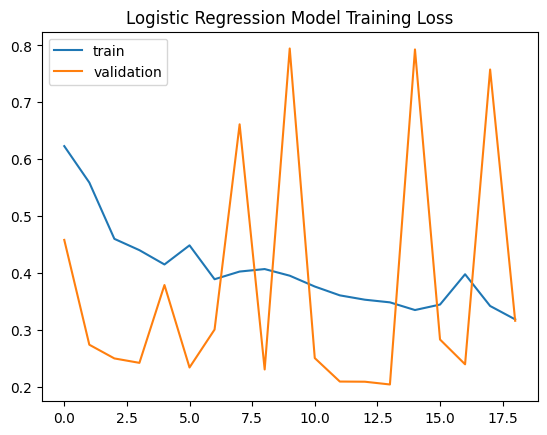

In [29]:
# graphing loss through epochs
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Logistic Regression Model Training Loss')
plt.legend()
plt.show()

63/63 [==============================] - 0s 2ms/step



Accuracy of logistic regression classifier on test set: 0.93
Precision of logistic regression classifier on test set: 0.77
Recall of logistic regression classifier on test set: 0.25


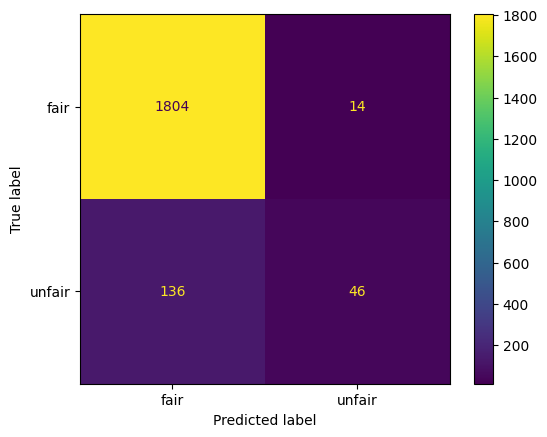

In [13]:

yhat_test = log_model.predict(X_test)

yhats = np.where(yhat_test > 0.5, 'fair', 'unfair')
y_test = np.where(y_test == 1, 'fair', 'unfair')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
myconfusionmatrix = confusion_matrix(y_test, yhats, labels = ['fair', 'unfair'])

disp = ConfusionMatrixDisplay(confusion_matrix=myconfusionmatrix,
                            display_labels= ['fair', 'unfair'])


disp.plot()

print ('\n\n\nAccuracy of logistic regression classifier on test set: {:.2f}'.format((myconfusionmatrix[0,0]+myconfusionmatrix[1,1])/myconfusionmatrix.sum()))
print('Precision of logistic regression classifier on test set: {:.2f}'.format(myconfusionmatrix[1,1]/(myconfusionmatrix[0,1]+myconfusionmatrix[1,1])))
print('Recall of logistic regression classifier on test set: {:.2f}'.format(myconfusionmatrix[1,1]/(myconfusionmatrix[1,0]+myconfusionmatrix[1,1])))

In [19]:
# Get the weights and biases from the model
weights, biases = log_model.layers[0].get_weights()

# Print the coefficients
print("Coefficients:", weights.flatten())
print("Intercept:", biases)

Coefficients: [ 1.4520781   0.91716915 -0.00301407 ...  0.00206154  0.6409905
 -0.39776182]
Intercept: [2.8947198]


In [35]:
# Calculate test error
loss, accuracy = log_model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 4ms/step - loss: 0.1808 - accuracy: 0.9320


In [38]:
print("Error on Final Training Epoch")
print(history.history['loss'][-1])
print("\n")
print("Error on Test Set")
print(loss)

# Significantly better due to stochasticity

Error on Final Training Epoch
0.3189215362071991


Error on Test Set
0.1808265745639801


In [15]:
pip install scikeras

In [18]:
from sklearn.model_selection import KFold, cross_validate
from scikeras.wrappers import KerasClassifier

estimator = KerasClassifier(model=log_model, epochs=100, batch_size=1, verbose=0, callbacks=[early_stopping])
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = cross_validate(estimator, X_train, y_train, cv=cv, n_jobs = 2, scoring= ["accuracy", "neg_mean_squared_error"])

KeyboardInterrupt: 

In [ ]:
current_iter = 1
while current_iter < 5:
  print(f"__Iteration {current_iter}__")
  print(f"Accuracy: {results['test_accuracy'][current_iter - 1]}")
  print(f"Mean Squared Error: {abs(results['test_neg_mean_squared_error'][current_iter - 1])}\n")
  current_iter += 1

print("------------------------\n")
print(f"__Overall Averages__")
print(f"Mean Accuracy: {results['test_accuracy'].sum() / len(results['test_accuracy'])}")
print(f"Mean MSE: {abs(results['test_neg_mean_squared_error']).sum() / len(results['test_neg_mean_squared_error'])}")

__Iteration 1__


NameError: name 'results' is not defined